In [1]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import grad, jit, vmap
from jax import random as jrandom
import jax

from jax import config
config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)

from typing import Sequence, Tuple, Union, Optional, Callable, Literal, Protocol
from jaxtyping import Array, ArrayLike, Float, Int, PyTree, PRNGKeyArray, ScalarLike

from jax_tqdm import scan_tqdm

import equinox as eqx

from dataclasses import dataclass, asdict, astuple
from functools import partial

jax.enable_checks = True

jax.devices()

[gpu(id=0)]

In [2]:

def plot_smoothing(xs, ys, dys):
    plt.plot(xs, ys, 'b.', markersize=1.0, label="values")
    plt.plot(xs, dys, 'r.', markersize=1.0, label="grads")
    plt.legend()
    plt.xlim([-1e-2, 1e-2])
    plt.ylim([-0.01, .01])
    # plt.show()

In [3]:
sharpness = 1e-2
bias = sharpness
smooth_max_fn = lambda x: jax.nn.celu(x=x, alpha=sharpness) + bias

def smooth_european_payoff(x, k):
    return jax.nn.celu(x=x-k, alpha=sharpness) + bias

ys_error 0.005049866680661472


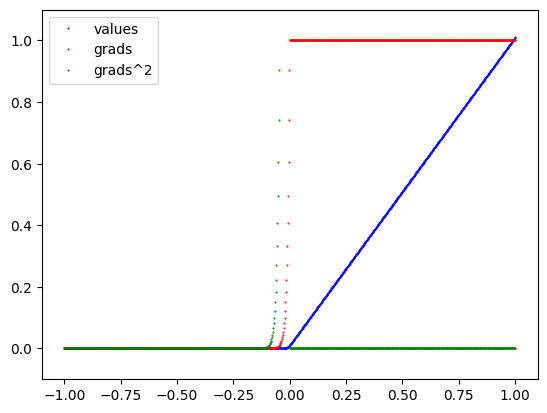

In [4]:
xs = jnp.linspace(-1, 1, 1000)
ys_true = jnp.maximum(0.0, xs)
fn = smooth_max_fn
ys, dys = jax.vmap(jax.value_and_grad(fn))(xs)
ddys = jax.vmap(jax.hessian(fn))(xs)

print("ys_error", jnp.mean(ys-ys_true))

plt.plot(xs, ys, 'b.', markersize=1.0, label="values")
plt.plot(xs, dys, 'r.', markersize=1.0, label="grads")
plt.plot(xs, ddys, 'g.', markersize=1.0, label="grads^2")
plt.legend()
# plt.xlim([-1e0, 1e0])
plt.ylim([-.1, 1.1])
plt.show()

In [5]:
jax.grad(lambda x: jnp.maximum(x, 0.0))(0.6)

Array(1., dtype=float64, weak_type=True)

In [6]:
class ModelState(eqx.Module):
    S0: float
    v0: float
    
class Heston(eqx.Module):

    # the state of the model at any given 
    class State(eqx.Module):
        S0: float
        v0: float
        
    # European call option price is at 34.99 for the following config: 
    class Parameters(eqx.Module):
        K: float = 100.0        # Strike price
        r: float = 0.05         # Risk-free rate
        T: float = 5.0          # n years until expiry, i.e. T2 - T1
        rho: float = -0.3       # Correlation of asset and volatility
        kappa: float = 2.00     # Mean-reversion rate
        theta: float = 0.09     # Long run average volatility
        xi: float = 1.00        # Volatility of volatility
     
    K: float = 100.0        # Strike price
    r: float = 0.05         # Risk-free rate
    T: float = 5.0          # n years until expiry, i.e. T2 - T1
    rho: float = -0.3       # Correlation of asset and volatility
    kappa: float = 2.00     # Mean-reversion rate
    theta: float = 0.09     # Long run average volatility
    xi: float = 1.00        # Volatility of volatility

    S0: float = 100.0       # Initial spot price
    v0: float = 0.09        # Initial volatility

    @classmethod
    def from_parameters(cls, parameters: Parameters, **kwargs):
        return cls(*astuple(parameters), **kwargs)
    
    @property
    def model_state(self) -> ModelState:
        return ModelState(self.S0, self.v0)


In [7]:
# https://arxiv.org/pdf/1606.06143.pdf

In [8]:
def volatility_path(self, vol_draws):
    n_steps = len(vol_draws)
    dt = self.T / n_steps

    def vol_path_iter(prev_vol_path, vol_draw):
        # v_truncated = smooth_max_fn(prev_vol_path)
        v_truncated = jnp.maximum(prev_vol_path, 0)
        prev_path_contribution = prev_vol_path + self.kappa * dt * (self.theta - v_truncated)
        randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draw
        current = prev_path_contribution + randomness
        return current, current # use current both for carry and for y

    carry, vol_path = jax.lax.scan(vol_path_iter, jnp.array(self.v0), vol_draws, length=n_steps)
    
    # we now have iteration 1 at position 0. Place initial v0 at the end and rotate into initial slot
    vol_path = jnp.roll(vol_path.at[-1].set(self.v0), 1)
    return vol_path


def spot_path(self, spot_draws: Array, vol_path: Array) -> Array:
    n_steps = len(spot_draws)
    dt = self.T / n_steps

    def spot_path_iter(prev_spot_path, iter_pair):
        spot_draw = iter_pair[0]
        vol = iter_pair[1]
        # v_truncated = smooth_max_fn(vol)
        v_truncated = jnp.maximum(vol, 0)
        # path_new_spot = prev_spot_path * jnp.exp((self.r - 0.5 * v_truncated) * dt + jnp.sqrt(v_truncated) * jnp.sqrt(dt) * spot_draw)
        
        path_new_spot = prev_spot_path + self.r * prev_spot_path * dt + jnp.sqrt(v_truncated) * prev_spot_path * jnp.sqrt(dt) * spot_draw
        
        return path_new_spot, path_new_spot

    iter_values = jnp.column_stack((spot_draws, vol_path))
    carry, spot_paths = jax.lax.scan(spot_path_iter, jnp.array(self.S0), iter_values, length=n_steps)
    
    # we now have iteration 1 at position 0. Place initial S0 at the end and rotate into initial slot
    spot_paths = jnp.roll(spot_paths.at[-1].set(self.S0), 1)
    return spot_paths[-1]


def state_path(self, vol_draws: Array, spot_draws: Array) -> Array:
    n_steps = len(spot_draws)
    dt = self.T / n_steps

    def state_path_iter(prev_state, iter_rng_pair):
        vol_draw, spot_draw = iter_rng_pair
        v, S = prev_state
        v_truncated = smooth_max_fn(v)
        # v_truncated = jnp.maximum(v, 0)
        v = v + self.kappa * (self.theta - v_truncated) * dt + self.xi * jnp.sqrt(v_truncated * dt) * vol_draw
        S = S + self.r * S * dt + jnp.sqrt(v_truncated) * S * jnp.sqrt(dt) * spot_draw
        # S = S * jnp.exp((self.r - 0.5 * v_truncated) * dt + jnp.sqrt(v_truncated * dt) * spot_draw)
        
        state = (v, S)
        return state, state

    iter_values = jnp.column_stack((vol_draws, spot_draws))
    init_state = (self.v0, self.S0)
    end_state, path = jax.lax.scan(state_path_iter, init_state, iter_values, length=n_steps)
    return end_state

In [9]:

def payoff(self, spot_path):
    spot_maturity = spot_path#[-1] # taking only the last element is specific to the european payoff
    # smooth_payoff_fn = cubic_spline_smoothing(payoff_fn)
    smooth_payoff_fn = smooth_european_payoff
    payoff = smooth_payoff_fn(spot_maturity, self.K)
    return payoff

# def model_state_path(self: Heston, vol_draws, spot_draws):
#     vol_path = volatility_path(self, vol_draws)
#     # X_n_1, Y_n_1 = jax.value_and_grad(spot_path)(self, spot_draws, vol_path)
#     X_n_1, vjp_fn = jax.vjp(partial(spot_path, spot_draws=spot_draws, vol_path=vol_path), self)
#     Y_n_1 = vjp_fn(jnp.ones(X_n_1.shape))[0]
#     print(Y_n_1.S0)
    
#     V_n_1 = vol_path[-1]
#     return V_n_1, X_n_1, Y_n_1 


def model_state_path(h: Heston, vol_draws, spot_draws):
    # X_n_1, Y_n_1 = jax.value_and_grad(state_path)(h, vol_draws, spot_draws)
    (V_n_1, X_n_1), vjp_fn = jax.vjp(partial(state_path, vol_draws=vol_draws, spot_draws=spot_draws), h)
    Y_n_1 = vjp_fn((1.0, 1.0))[0]
    return V_n_1, X_n_1, Y_n_1


def path_and_payoff(self, vol_draws, spot_draws):

    n = vol_draws.shape[0]
    # time step
    h = self.T / n
    
    # spot_path is X^n
    # adjoint_path is Y^n
    V_n_1, X_n_1, Y_n_1 = model_state_path(self, vol_draws, spot_draws)
    V_n_1 = jnp.maximum(V_n_1, 1e-7)
    # print(Y_n_1)
    Z_n_1 = spot_draws[-1]

    # TODO: right now we preselect S0 to get the delta and gamma. In general we might be interested in other greeks.
    # jax.tree_util.tree_map(lambda x: print(x), Y_n_1)
    # print(jax.tree_util.tree_structure(Y_n_1))
    
    # Y_n_1 = Y_n_1.S0
    
    # V_T is the payoff
    V_T = payoff(self, X_n_1)
    # V_n_1 = jnp.maximum(V_n_1, 0.0)
    # assert(V_n_1 >= 0.0)
    # print(V_n_1)

    def delta_n_fn(V_n_1, X_n_1, Y_n_1, Z_n_1):
        
        X_Tp   = X_n_1 + self.r * h * X_n_1 + jnp.sqrt(V_n_1) * X_n_1 * jnp.sqrt(h) * Z_n_1
        X_Tm   = X_n_1 + self.r * h * X_n_1 - jnp.sqrt(V_n_1) * X_n_1 * jnp.sqrt(h) * Z_n_1
        X_Tdot = X_n_1 + self.r * h * X_n_1
        V_Tp   = payoff(self, X_Tp)
        V_Tm   = payoff(self, X_Tm)
        V_Tdot = payoff(self, X_Tdot)
        
        # Pathwise delta using vibrato at maturity using eq. (6.6), Gilles Pages
        delta_n = Y_n_1 * (1.0 + self.r * h) * 1/2 * (V_Tp - V_Tm) * Z_n_1 / (X_n_1 * jnp.sqrt(V_n_1) * jnp.sqrt(h)) \
                + Y_n_1 * jnp.sqrt(V_n_1) * jnp.sqrt(h) * 1/2 * (V_Tp - 2.0 * V_Tdot + V_Tm) * (Z_n_1**2 - 1.0) / (X_n_1 * jnp.sqrt(V_n_1) * jnp.sqrt(h))

        return delta_n

    # these are really only pathwise "deltas"/"gammas"
    delta_n, gamma_n = jax.value_and_grad(delta_n_fn, 1)(V_n_1, X_n_1, Y_n_1.S0, Z_n_1)
    vega_n, vomma_n = jax.value_and_grad(delta_n_fn, 0)(V_n_1, X_n_1, Y_n_1.v0, Z_n_1)
    

    # computing the last step
    # adding the vibrato
    # page 7 first equation
    # Y_hat = 

    return V_T, delta_n, gamma_n, vega_n, vomma_n


# def path_and_payoff(self, vol_draws, spot_draws):
#     V_n_1, X_n_1, Y_n_1 = model_state_path(self, vol_draws, spot_draws)
#     return payoff(self, X_n_1)

In [10]:

@eqx.filter_jit
def correlated_draws(self: Heston, key, n_samples: int):
    mean = jnp.zeros(2)
    cov = jnp.array([[1.0, self.rho], [self.rho, 1.0]])
    
    correlated_samples = jrandom.multivariate_normal(key, mean, cov, shape=(n_samples,))
    vol_draws = correlated_samples[:, 0]
    spot_draws = correlated_samples[:, 1]
    return vol_draws, spot_draws
    
def path(self: Heston, key: PRNGKeyArray, n_time_steps: int = 1024):
    vol_draws, spot_draws = correlated_draws(self, key, n_time_steps)
    return path_and_payoff(self, vol_draws, spot_draws)


def differential_path(self: Heston, key: PRNGKeyArray, n_time_steps: int = 1024):
    vol_draws, spot_draws = correlated_draws(self, key, n_time_steps)
    return jax.value_and_grad(path_and_payoff)(self, vol_draws, spot_draws)

In [11]:
key = jrandom.PRNGKey(0)

h = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.00,
    v0 = 0.09, 
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0,
)

h2 = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.0319,
    v0 = 0.010201, 
    T = 1.0,
    rho = -0.7,
    kappa = 6.21,
    theta = 0.019,
    xi = 0.61,
)

h3 = Heston(
    S0 = 100.0,
    v0 = 0.028087,
    K = 90.0,        # Strike price
    r = 0.00135,         # Risk-free rate
    T = 1.0,          # n years until expiry, i.e. T2 - T1
    rho = 0.5,       # Correlation of asset and volatility
    kappa = 2.931465,     # Mean-reversion rate
    theta = 0.101,     # Long run average volatility
    xi = 0.01,        # Volatility of volatility
)

h4 = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.00,
    v0 = 0.04, 
    T = 1.0,
    rho = -0.9,
    kappa = 0.5,
    theta = 0.04,
    xi = 1.00,
)

h = h
path(h, key)
# differential_path(h, key)

(Array(8.19357185, dtype=float64),
 Array(1.54322915, dtype=float64),
 Array(0., dtype=float64),
 Array(-47.7593455, dtype=float64),
 Array(-0.00120065, dtype=float64))

In [12]:
key = jrandom.PRNGKey(0)
keys = jrandom.split(key, 10000)

paths = jax.jit(jax.vmap(partial(path, h, n_time_steps=1024)))(keys)
# price, delta, gamma, vega, vomma = jax.tree_util.tree_map(lambda x: jnp.mean(x) * jnp.exp(-h.r * h.T), paths)

# print(price)
# print(delta)
# print(gamma)
# print(vega)
# print(vomma)
price = jax.tree_util.tree_map(lambda x: jnp.mean(x) * jnp.exp(-h.r * h.T), (paths,))
print(price)
# print(greeks.v0)

((Array(10.20540898, dtype=float64), Array(0.61697125, dtype=float64), Array(0.01601881, dtype=float64), Array(37.82677203, dtype=float64), Array(-151.08970558, dtype=float64)),)


In [49]:
def test_readme_scan_example(print_rate):
    """Just test that README scan example runs correctly"""

    n = 10_000

    @scan_tqdm(n)
    def step(carry, x):
        print(x)
        # jax.debug.print("{}", x)
        return carry + 1, carry + 1

    key = jrandom.PRNGKey(0)
    keys = jrandom.split(key, n)
    last_number, all_numbers = jax.lax.scan(step, 0, (jnp.arange(n), keys))

    assert int(last_number) == n
    assert jnp.array_equal(all_numbers, 1 + jnp.arange(n))


test_readme_scan_example(10)

(Traced<ShapedArray(int64[])>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(uint32[2])>with<DynamicJaxprTrace(level=1/0)>)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
class ScanState(eqx.Module):
    payoff_sum: Array
    dpayoff_sum: ModelState
    
    def __iter__(self):
        return iter(astuple(self))

@eqx.filter_jit
def price(heston: Heston, *, key: PRNGKeyArray, n_multiplier: int = 1):
    n_simulations = 100000 * n_multiplier
    n_outside_iter = 100 * n_multiplier
    n_sims_per_iter = n_simulations // n_outside_iter
    payoff_sum: float = 0.0
    n_states = heston.S0.shape[0]

    if n_simulations % n_states:
        raise ValueError("n_states must be divisor of 1000")

    def pathwise_payoff_fn(pp: ScanState, key):
        payoff_sum = pp.payoff_sum
        dpayoff_sum = pp.dpayoff_sum
        
        def payoff(heston, key):
            keys_path = jrandom.split(key, num=n_sims_per_iter)
            keys_path = jnp.reshape(keys_path, (n_sims_per_iter//n_states, n_states, 2))
            
            res, dres = jax.vmap(lambda x: eqx.filter_vmap(path)(heston, x))(keys_path)
            # print("res.shape: ", res)
            pathwise_payoff = jnp.reshape(res, n_sims_per_iter)
            dpayoff = dres
            return pathwise_payoff, dpayoff


        pathwise_payoff, dpayoff = payoff(heston, key)
        
        dpayoff_sum_iter = jax.tree_util.tree_map(lambda x: jnp.sum(x, axis=0), dpayoff)
        # print("dpayoff_sum_iter: {}", dpayoff_sum_iter)
        
        payoff_sum_iter = jnp.sum(pathwise_payoff, axis=0)
        payoff_sum += payoff_sum_iter
        dpayoff_sum = ModelState(dpayoff_sum.S0 + dpayoff_sum_iter.S0, dpayoff_sum.v0 + dpayoff_sum_iter.v0)
        # dpayoff_sum 
        return ScanState(payoff_sum, dpayoff_sum), pathwise_payoff
        # return pp, payoff_sum_iter

    keys = jrandom.split(key, num=n_outside_iter)
    
    # print("heston.n_states: :", n_states)
    (payoff_sum, dpayoff_sum), pathwise_payoffs = jax.lax.scan(pathwise_payoff_fn, ScanState(jnp.zeros(n_states), ModelState(jnp.zeros(n_states), jnp.zeros(n_states))), keys, length=n_outside_iter)
    # print(payoff_sum)
    # option_price = (payoff_sum / n_simulations) * jnp.exp(-heston.r * heston.T)
    return (payoff_sum, dpayoff_sum), pathwise_payoffs

In [23]:
class Range(eqx.Module):
    minval: float = 0.0
    maxval: float = 1.0
    
@eqx.filter_jit
def test_set_precomputed(params: Heston.Parameters, *, key: PRNGKeyArray, spot_range: Range, vol_range: Range):

    minvals = jnp.array([spot_range.minval, vol_range.minval])
    maxvals = jnp.array([spot_range.maxval, vol_range.maxval])
    n_outer_paths = 2**12
    
    @scan_tqdm(n_outer_paths, print_rate=10)
    def monte_carlo(carry, key):
        _, key = key
        n_inner_paths = 2**13
        key, key_state = jrandom.split(key)

        # inisde the inner loop of the test set we always use the same initial state to determine the price afterwards.
        initial_states = jnp.ones((n_inner_paths, 2)) * jrandom.uniform(key_state, shape=(2,), minval=minvals, maxval=maxvals)
        initial_spots = initial_states[:, 0]
        initial_vols = initial_states[:, 1]
        
        # jax.debug.print("initial spots {}", initial_spots)
        
        hs = Heston.from_parameters(params, S0=initial_spots, v0=initial_vols)
        
        path_seeds = jrandom.split(key, n_inner_paths)
        # ps, dps, ddps, dvs, ddvs = eqx.filter_vmap(partial(path, n_time_steps=1024))(hs, path_seeds)
        res = eqx.filter_vmap(partial(path, n_time_steps=1024))(hs, path_seeds)
        
        # jax.debug.print("finished price calcuation {}", carry)
        return carry + 1, (initial_states, res)
    
    # due to limited vram of gpu we need to split up the computation into outer and inner paths.

    key, subkey = jrandom.split(key)
    key_rngs = jrandom.split(subkey, n_outer_paths)
    carry, ds = jax.lax.scan(monte_carlo, 0, (jnp.arange(n_outer_paths), key_rngs))

    # jax.debug.print("ds payoffs {}", ds.payoffs.shape)
    # jax.debug.print("ds payoffs {}", ds.payoffs)

    def discounted_avg(x, h: Heston.Parameters):
        return jnp.mean(x, axis=1) * jnp.exp(-h.r * h.T) 
    
    test_set = jax.tree_util.tree_map(partial(discounted_avg, h=hs_params), ds)

    # jax.debug.print("test set {}", test_set)
    
    return test_set

In [56]:
key = jrandom.PRNGKey(0)

spot_range = Range(100.0, 100.0)
vol_range = Range(0.09, 0.09)

hs_params = Heston.Parameters(
    K = 100.0,   
    r = 0.00,
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0,
)

# spot_range = Range(100.0, 100.0)
# vol_range = Range(0.04, 0.04)

# hs_params = Heston.Parameters(
#     K = 100.0,   
#     r = 0.00,
#     T = 1.0,
#     rho = -0.9,
#     kappa = 0.5,
#     theta = 0.04,
#     xi = 1.00,
# )

# spot_range = Range(100.0, 100.0)
# vol_range = Range(0.010201, 0.010201)

# hs_params = Heston.Parameters(
#     K = 100.0,   
#     r = 0.0319,
#     T = 1.0,
#     rho = -0.7,
#     kappa = 6.21,
#     theta = 0.019,
#     xi = 0.61,
# )

# spot_range = Range(85.0, 85.0)
# vol_range = Range(0.028087, 0.028087)

# hs_params = Heston.Parameters(
#     K = 90.0,        # Strike price
#     r = 0.00135,         # Risk-free rate
#     T = 1.0,          # n years until expiry, i.e. T2 - T1
#     rho = 0.5,       # Correlation of asset and volatility
#     kappa = 2.931465,     # Mean-reversion rate
#     theta = 0.101,     # Long run average volatility
#     xi = 0.01,        # Volatility of volatility
# )

test_set = test_set_precomputed(params=hs_params, key=key, spot_range=spot_range, vol_range=vol_range)

  0%|          | 0/1024 [00:00<?, ?it/s]

In [57]:
jax.tree_util.tree_map(jnp.mean, test_set)

(Array(10.33799513, dtype=float64),
 Array(0.60833827, dtype=float64),
 Array(0.01995386, dtype=float64),
 Array(37.55093936, dtype=float64),
 Array(-37.14237625, dtype=float64))

In [24]:
key = jrandom.PRNGKey(1)

spot_range = Range(50.0, 150.0)
vol_range = Range(0.01, 0.09)

hs_params = Heston.Parameters(
    K = 100.0,   
    r = 0.00,
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0,
)

test_set_multi = test_set_precomputed(params=hs_params, key=key, spot_range=spot_range, vol_range=vol_range)

  0%|          | 0/4096 [00:00<?, ?it/s]

In [25]:
xs, (ys, ds, dsds, dv, dvdv) = test_set_multi

In [26]:
def plot_differential_data(init_spots, init_vols, payoffs, states: ModelState):
    # plt.plot(init_spots, payoffs, 'b.', markersize=1.0, label = 'payoffs')
    plt.plot(init_spots, states.S0, 'r.', markersize=1.0, label = 'dpayoff/dS0')

    print(init_spots.shape)
    print(states.S0.shape)
    # plt.plot(init_spots, states
    # plt.plot(hset.initial_spot_prices, prices, 'r.', markersize=3, label='price')
    plt.legend()
    plt.xlabel('initial spot price')
    plt.ylabel('payoff')
    # plt.ylim(-1, 1000)
    plt.show()

def plot_3d_differential_data(init_spots, init_vols, differential_data, label):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(init_spots, init_vols, differential_data, c=differential_data, cmap=plt.cm.viridis)
    
    # Add a colorbar to show the mapping of colors to z-values
    cbar = fig.colorbar(sc)
    cbar.set_label(label)
    
    ax.set_title(label)
    ax.set_xlabel("initial spot price")
    ax.set_ylabel("initial volatility")
    ax.set_zlabel(label)
    return fig


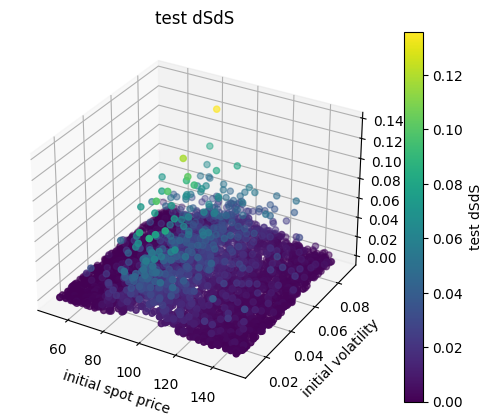

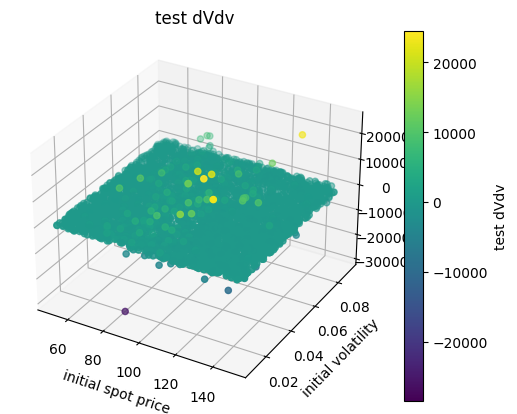

In [27]:
xs, ys = xs[:, 0], xs[:, 1]
fig_dSdS = plot_3d_differential_data(xs, ys, dsds, "test dSdS")
fig_dVdV = plot_3d_differential_data(xs, ys, dvdv, "test dVdv")